# 0.1 imports

In [130]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

from sklearn.metrics import mean_squared_error, mean_absolute_error

# 0.2 helpers functions

In [131]:
# def plot_gdp(dataframe, countrys, print_legend=True):
    
#     countrys_with_year = countrys + ['year']
#     df=dataframe[countrys_with_year].copy()
#     # Create a list of colors
#     color_discrete_sequence = [
#         'navy', 'orange', 'tomato', 'crimson', 'darkgreen', 'brown',
#         'forestgreen', 'steelblue',
#     ]

#     # Create a list of traces
#     traces = []
#     for j, seleccion in enumerate(countrys):
#         trace = go.Scatter(
#             x=df['year'],
#             y=df[seleccion],
#             mode='lines+markers',
#             name=seleccion,
#             marker=dict(color=color_discrete_sequence[j % len(color_discrete_sequence)]),
#         )
#         traces.append(trace)

#     # Create the figure
#     fig = go.Figure(traces)

#     # Configure the layout
#     fig.update_layout(
#         title='GDP',
#         title_font_size=30,
#         plot_bgcolor='#F7FAFC',
#         xaxis=dict(tickangle=30),
#         yaxis=dict(tickformat=',.0f'),
#         xaxis_dtick='2',
#         xaxis_title='Year',
#         yaxis_title='Real GDP growth (Annual percent change)',
#         legend_title_text='Legend',
#         legend=dict(x=0, y=1) if print_legend == True else {},
#         showlegend=True if print_legend == True else False,
#         margin=dict(l=0, r=0, t=50, b=0),
#         template='plotly',
#         height=800,
#         width=1200,
#     )

#     return fig


In [132]:
def plot_gdp(dataframe, countrys, print_legend=True):
    countrys_with_year = countrys + ['year']
    df = dataframe[countrys_with_year].copy()

    color_palette = [
        'navy', 'orange', 'tomato', 'crimson', 'darkgreen', 'brown',
        'forestgreen', 'steelblue',
    ]
    
    plt.figure(figsize=(12, 8))

    for seleccion in countrys:
        sns.lineplot(x='year', y=seleccion, data=df, label=seleccion)#, color=color_palette[j % len(color_palette)])

    plt.title('GDP', fontsize=20)
    plt.xlabel('Year')
    plt.ylabel('Real GDP growth (Annual percent change)')
    plt.xticks(rotation=30)
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: format(int(x), ',')))
    
    if print_legend:
        plt.legend(title='Legend', loc='upper left')
    else:
        plt.legend().set_visible(False)
    
    plt.tight_layout()
    plt.grid()
    plt.show()

In [133]:

def fill_individual_countries(dataframe, countries):
    
    df = dataframe[countries+['year']].copy()

    check_na = df.isna().sum()
    null_values = list(check_na[check_na>0].index)

    complete_group = list(check_na[check_na==0].index)
    complete_group.remove('year')
    # complete_group.remove('Sub-Saharan Africa (Region) ')

    df_complete_group = dataframe[complete_group]

    df_aux = pd.DataFrame()

    df_aux["year"] = dataframe["year"]
    df_aux["year_average"] = df_complete_group.mean(axis=1)


    for country in null_values:

        df_aux[country] = dataframe[country]

        aux = df_aux[~df_aux[country].isna()]

        aux['test'] = (aux[country] > aux['year_average']).astype(int)


        most_common = aux['test'].value_counts().idxmax()

        if most_common == 0:
            df_aux.loc[df_aux[country].isna(), country] = df_aux.loc[df_aux[country].isna(), "year_average"] - df_aux[country].std()
        else:
            df_aux.loc[df_aux[country].isna(), country] = df_aux.loc[df_aux[country].isna(), "year_average"] + df_aux[country].std()

    return df_aux

In [134]:
# MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [135]:

def metrics(y_true, y_pred,model_name):
    y_true = y_true.values
    y_pred = y_pred.values
    mae = round(mean_absolute_error(y_true, y_pred),5)
    rmse = round(np.sqrt(mean_squared_error(y_true, y_pred)),5)
    mape = round(mean_absolute_percentage_error(y_true, y_pred),5)
    metrics = pd.DataFrame({'Model': model_name,'mae': mae, 'rmse': rmse, 'mape': mape}, index=[0])
    return metrics



# 0.3 load data

In [136]:
path = '/home/lavino/Documentos/projetos_indicium/ds_desafio/'

In [137]:
df_raw = pd.read_csv(path + 'data/df_fill.csv', index_col='year', parse_dates=True)

In [138]:
df_raw.head()

,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Aruba,Australia,...,Emerging and Developing Europe,Emerging market and developing economies,Euro area,European Union,Latin America and the Caribbean,Major advanced economies (G7),Middle East and Central Asia,Other advanced economies,Sub-Saharan Africa,World
year,,,,,,,,,,,,,,,,,,,,,
1980-01-01,4.206173,2.7,-5.4,-1.732417,2.4,8.2,0.7,2.776923,8.187232,2.9,...,-0.8,3.3,3.487831,1.8,6.4,0.9,-1.9,3.8,1.917685,2.1
1981-01-01,7.200000,5.7,3.0,-3.196477,-4.4,3.8,-5.7,1.478698,7.687026,4.1,...,-0.5,1.9,0.914286,0.1,0.9,2.0,-0.2,4.2,1.732500,1.9
1982-01-01,5.116667,2.9,6.4,-2.925252,0.0,-0.1,-3.1,0.180473,6.675762,0.1,...,1.4,1.5,1.242857,0.6,-0.5,-0.1,0.4,2.2,1.950000,0.7
1983-01-01,4.283333,1.1,5.4,-2.284511,4.2,5.4,3.7,-1.117751,8.090579,-0.5,...,4.6,1.8,1.607143,1.7,-2.8,3.3,0.7,4.0,1.272500,2.6
1984-01-01,6.166667,2.0,5.6,-1.317845,6.0,10.2,2.0,-2.415976,10.046980,6.3,...,4.1,4.1,2.621429,2.5,3.9,5.0,0.3,6.6,2.080000,4.6


In [139]:
df_raw = df_raw.asfreq(freq='AS')

In [140]:
df_raw['Afghanistan'] = df_raw['Afghanistan'].fillna(df_raw['Afghanistan'].mean())
df_raw['Lebanon'] = df_raw['Lebanon'].fillna(df_raw['Lebanon'].mean())
df_raw['Syria'] = df_raw['Syria'].fillna(df_raw['Syria'].mean())
df_raw['Ukraine'] = df_raw['Ukraine'].fillna(df_raw['Ukraine'].mean())
df_raw['Venezuela'] = df_raw['Venezuela'].fillna(df_raw['Venezuela'].mean())

# 1.0 Season decomposition - additive model

In [141]:
# country = 'Albania'
country = 'Sub-Saharan Africa (Region) '

## 1.1 plot

/tmp/ipykernel_93942/3501970588.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95]);


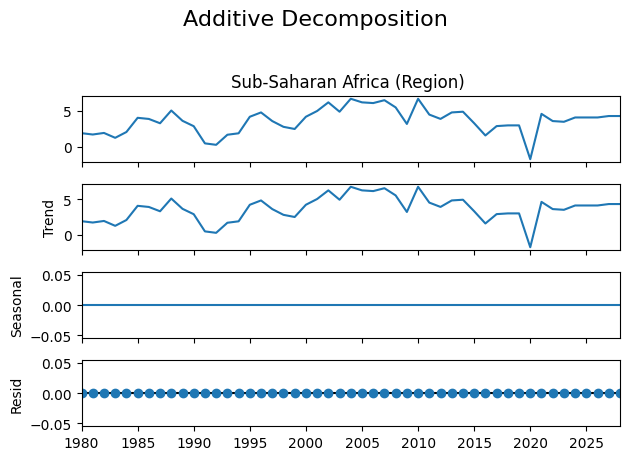

In [142]:
decomposition = seasonal_decompose(df_raw[country], model='additive', period=1)

decomposition.plot().suptitle('Additive Decomposition', fontsize=16);
plt.tight_layout(rect=[0, 0.03, 1, 0.95]);

## 1.2 adf test

In [143]:
stacionary_data = []
non_stacionary_data = []

for series in df_raw.columns:

    country_data = df_raw[[series]]

    # Realizando o teste ADF
    result = adfuller(country_data)

    # Interpretando os resultados do teste
    # print('ADF Statistic:', result[0])
    # print('p-value:', result[1])
    # print('Critical Values:', result[4])

    if result[1] <= 0.05:
        # print("A série é estacionária.")
        stacionary_data.append(series)
    else:
        # print("A série não é estacionária.")
        non_stacionary_data.append(series)


In [144]:
print("% das series temporais estácionárias:",(len(stacionary_data)/len(df_raw.columns)*100))
print("% das series temporais não estácionárias:",(len(non_stacionary_data)/len(df_raw.columns)*100))

% das series temporais estácionárias: 81.14035087719299
% das series temporais não estácionárias: 18.859649122807017


In [145]:
len(non_stacionary_data)

43

# 2.0 Models

In [146]:
df1 = df_raw.copy()

## 2.1 test train split

In [147]:
test_years = 5
train = df1[:-test_years]
test = df1[-test_years:]

## 2.2 exponencial smoothing

In [148]:
# exponential smoting
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [149]:
model_hot_winter = ExponentialSmoothing(
    train[country],
    trend='add',
    seasonal='add',
    seasonal_periods=12,
).fit()

In [150]:
pred_hot_winter = model_hot_winter.forecast(test.shape[0])

<Axes: xlabel='year'>

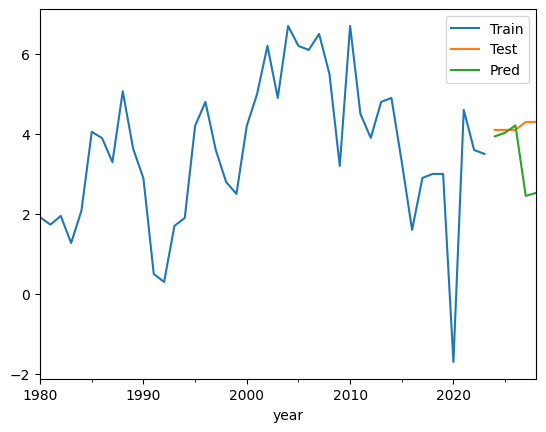

In [151]:
train[country].plot(legend=True, label='Train')
test[country].plot(legend=True, label='Test')
pred_hot_winter.plot(legend=True, label='Pred')

In [152]:
metrics(test[country], pred_hot_winter, 'Holt-Winters')

,Model,mae,rmse,mape
0,Holt-Winters,0.7936,1.14976,18.53417


## 2.2 Simple exponential smoothing

In [153]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [154]:
# simple exponetial smooting
model_ses = SimpleExpSmoothing(
    train[country],
    initialization_method='heuristic',                              
).fit(smoothing_level=0.2, optimized=True)

pred_ses = model_ses.forecast(test.shape[0])

/home/lavino/Documentos/projetos_indicium/ds_desafio/venv/lib/python3.10/site-packages/pandas/util/_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


<Axes: xlabel='year'>

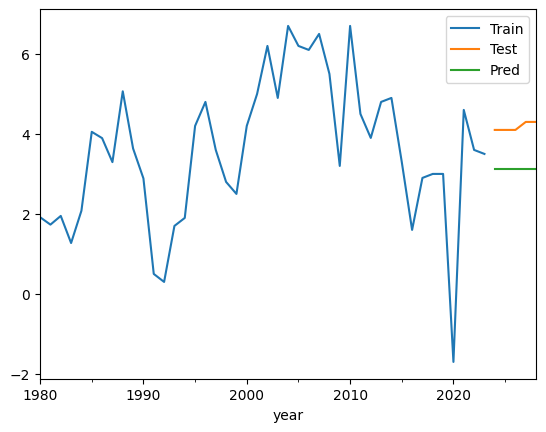

In [155]:
train[country].plot(legend=True, label='Train')
test[country].plot(legend=True, label='Test')
# pred_hot_winter.plot(legend=True, label='Pred')
pred_ses.plot(legend=True, label='Pred')

In [156]:
metrics_ses = metrics(test[country], pred_ses, 'Simple Exponential Smoothing')
metrics_ses

,Model,mae,rmse,mape
0,Simple Exponential Smoothing,1.05853,1.06306,25.28306


## 2.3 Sarimax

In [157]:
from pmdarima.arima import auto_arima

In [158]:
model_sarimax = auto_arima(
    train[country],
    m=1,
    test='adf',
    seasonal=False,
    stepwise=True,
    d=0,
    start_p=0,
    max_p=1,
    start_q=0,
    max_q=1,
)

In [159]:
pred_sarimax = model_sarimax.predict(test.shape[0])
pred_sarimax

2024-01-01    3.513981
2025-01-01    3.521420
2026-01-01    3.525379
2027-01-01    3.527485
2028-01-01    3.528606
Freq: AS-JAN, dtype: float64

<Axes: xlabel='year'>

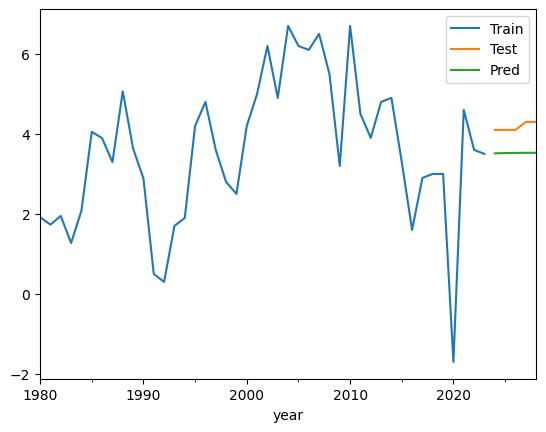

In [160]:
train[country].plot(legend=True, label='Train')
test[country].plot(legend=True, label='Test')
pred_sarimax.plot(legend=True, label='Pred')

In [161]:
metrics_sarimax = metrics(test[country], pred_sarimax, 'sarimax')
metrics_sarimax

,Model,mae,rmse,mape
0,sarimax,0.65663,0.66335,15.66497


## 2.4 Prophet

In [162]:
from prophet import Prophet
from prophet.diagnostics import cross_validation

11:20:29 - cmdstanpy - INFO - Chain [1] start processing


11:20:29 - cmdstanpy - INFO - Chain [1] done processing


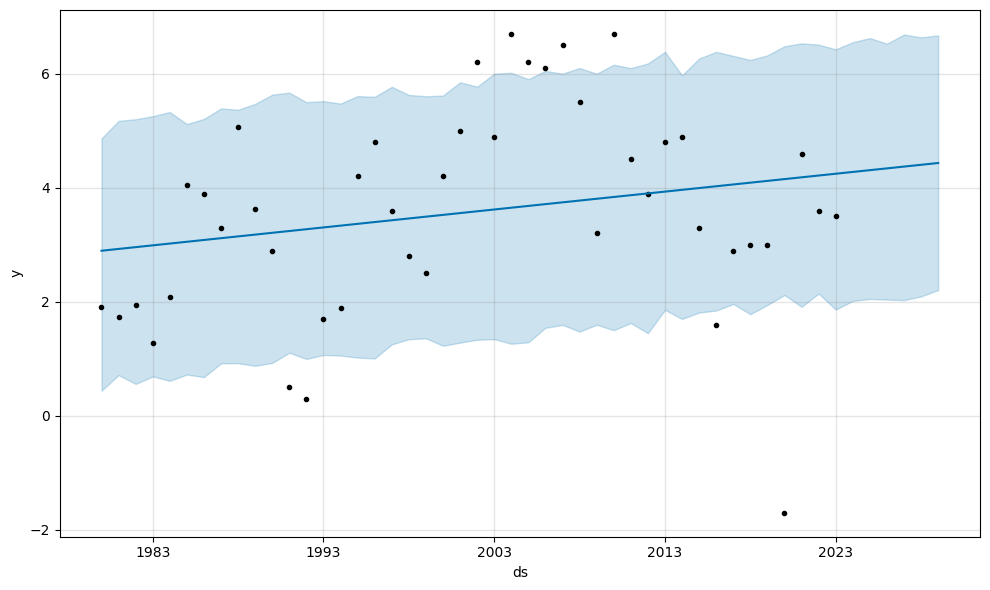

In [163]:

aux = train[[country]].copy()
aux['ds'] = aux.index
aux.rename(columns={country: 'y'}, inplace=True)
aux

# # Crie e ajuste o modelo
model_prophet = Prophet(
    growth='linear',
    seasonality_mode='additive',
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=0.1,
    seasonality_prior_scale=0,
)
model_prophet.fit(aux)


future = model_prophet.make_future_dataframe(periods=6, freq='YS')  
forecast = model_prophet.predict(future)


model_prophet.plot(forecast);

<Axes: xlabel='year'>

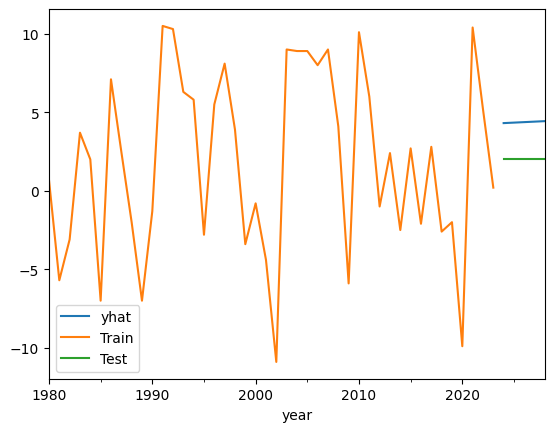

In [164]:
aux = forecast[['yhat']][-5:]
aux.index = test.index

aux.plot(legend=True, label='prophet');
train['Argentina'].plot(legend=True, label='Train')
test['Argentina'].plot(legend=True, label='Test')

In [165]:
metrics_prophet = metrics(test[country], aux['yhat'], 'prophet')
metrics_prophet

,Model,mae,rmse,mape
0,prophet,0.19308,0.20327,4.65475


In [166]:
df_cv = cross_validation(model_prophet, initial='365 days', parallel='processes', horizon='1825 days') 

11:20:30 - cmdstanpy - INFO - Chain [1] start processing
11:20:30 - cmdstanpy - INFO - Chain [1] start processing
11:20:30 - cmdstanpy - INFO - Chain [1] start processing
11:20:30 - cmdstanpy - INFO - Chain [1] start processing
11:20:31 - cmdstanpy - INFO - Chain [1] done processing
11:20:31 - cmdstanpy - INFO - Chain [1] done processing
11:20:31 - cmdstanpy - INFO - Chain [1] done processing
11:20:31 - cmdstanpy - INFO - Chain [1] done processing
11:20:31 - cmdstanpy - INFO - Chain [1] start processing
11:20:31 - cmdstanpy - INFO - Chain [1] start processing
11:20:31 - cmdstanpy - INFO - Chain [1] start processing
11:20:31 - cmdstanpy - INFO - Chain [1] done processing
11:20:31 - cmdstanpy - INFO - Chain [1] start processing
11:20:31 - cmdstanpy - INFO - Chain [1] done processing
11:20:31 - cmdstanpy - INFO - Chain [1] done processing
11:20:31 - cmdstanpy - INFO - Chain [1] start processing
11:20:31 - cmdstanpy - INFO - Chain [1] start processing
11:20:31 - cmdstanpy - INFO - Chain [1

In [167]:
metrics_prophet_cv = metrics(df_cv.y, df_cv.yhat, 'Prophet CV')
metrics_prophet_cv

,Model,mae,rmse,mape
0,Prophet CV,2.17888,2.64882,132.5973


# 3.0 Exogen variables

## 3.1 Sarimax

In [168]:
# exog = df1[['South America','World']]
# exog = df1[['South America']]
exog = df1[['World']]
train_exog = exog[:-test_years]
test_exog = exog[-test_years:]

In [169]:
model_sarimax = auto_arima(
    y=train[country],
    X=train_exog,
    m=12,
    test='adf',
    seasonal=False,
    stepwise=True,
    d=0,
    start_p=0,
    max_p=1,
    start_q=0,
    max_q=1,
)

/home/lavino/Documentos/projetos_indicium/ds_desafio/venv/lib/python3.10/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


In [170]:
pred_sarimax = model_sarimax.predict(test.shape[0],X=test_exog)
pred_sarimax

2024-01-01    3.273192
2025-01-01    3.449006
2026-01-01    3.449006
2027-01-01    3.370715
2028-01-01    3.292424
Freq: AS-JAN, dtype: float64

<Axes: xlabel='year'>

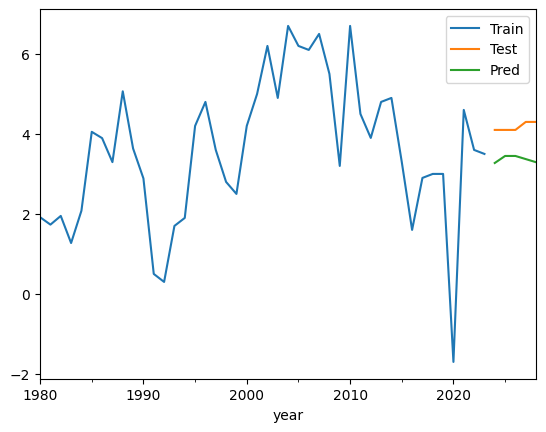

In [171]:
train[country].plot(legend=True, label='Train')
test[country].plot(legend=True, label='Test')
pred_sarimax.plot(legend=True, label='Pred')

In [172]:
metrics_sarimax = metrics(test[country], pred_sarimax, 'sarimax')
metrics_sarimax

,Model,mae,rmse,mape
0,sarimax,0.81313,0.82583,19.39303


## 3.2 Prophet

In [173]:
df2 = df1.copy()

In [174]:
df2['ds'] = df2.index

In [175]:
test_years = 5
train_pp = df2[:-test_years]
test_pp = df2[-test_years:]

11:20:33 - cmdstanpy - INFO - Chain [1] start processing


11:20:33 - cmdstanpy - INFO - Chain [1] done processing


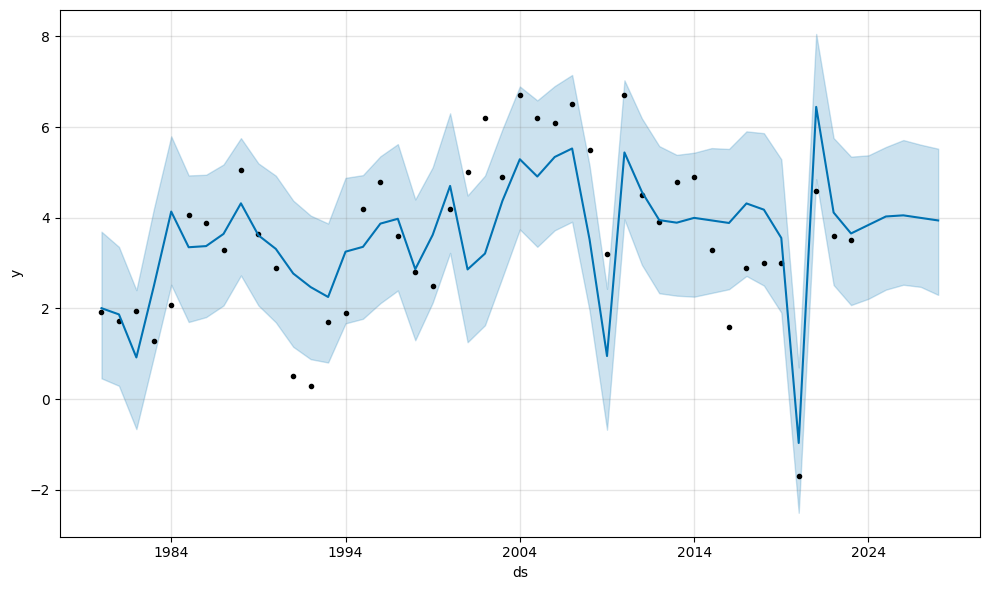

In [176]:

aux = pd.DataFrame()
aux['ds'] = df2['ds'].values
aux['y'] = df2[country].values
aux['World'] = df2['World'].values
# aux['South America'] = df2['South America'].values

test_years = 5
train_pp = aux[:-test_years]
test_pp = aux[-test_years:]

# Crie e ajuste o modelo
model_prophet = Prophet(
    growth='linear',
    seasonality_mode='additive',
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=0.1,
    seasonality_prior_scale=0,
)
model_prophet.add_regressor('World')
# model_prophet.add_regressor('South America')
model_prophet.fit(train_pp)


future = model_prophet.make_future_dataframe(periods=test_years, freq='YS')  

# future = pd.concat([future, aux[['World','South America']]], axis=1)
future = pd.concat([future, aux[['World']]], axis=1)


forecast = model_prophet.predict(future)


model_prophet.plot(forecast);

<Axes: xlabel='year'>

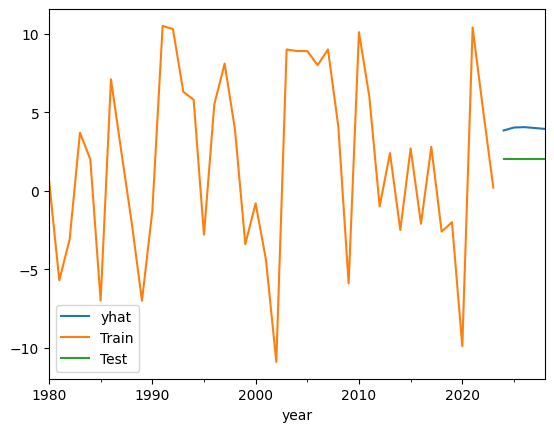

In [177]:
aux = forecast[['yhat']][-5:]
aux.index = test.index

aux.plot(legend=True, label='prophet');
train['Argentina'].plot(legend=True, label='Train')
test['Argentina'].plot(legend=True, label='Test')


In [178]:
metrics_prophet = metrics(test[country], aux['yhat'], 'prophet')
metrics_prophet

,Model,mae,rmse,mape
0,prophet,0.20721,0.24241,4.90402


In [179]:
from prophet.diagnostics import cross_validation

In [180]:
df_cv = cross_validation(model_prophet, initial='365 days', parallel='processes', horizon='1825 days') 

11:20:34 - cmdstanpy - INFO - Chain [1] start processing
11:20:34 - cmdstanpy - INFO - Chain [1] start processing
11:20:34 - cmdstanpy - INFO - Chain [1] start processing
11:20:34 - cmdstanpy - INFO - Chain [1] start processing
11:20:34 - cmdstanpy - INFO - Chain [1] done processing
11:20:34 - cmdstanpy - INFO - Chain [1] done processing
11:20:34 - cmdstanpy - INFO - Chain [1] done processing
11:20:34 - cmdstanpy - INFO - Chain [1] done processing
11:20:34 - cmdstanpy - INFO - Chain [1] start processing
11:20:34 - cmdstanpy - INFO - Chain [1] start processing
11:20:34 - cmdstanpy - INFO - Chain [1] done processing
11:20:34 - cmdstanpy - INFO - Chain [1] start processing
11:20:34 - cmdstanpy - INFO - Chain [1] done processing
11:20:34 - cmdstanpy - INFO - Chain [1] done processing
11:20:34 - cmdstanpy - INFO - Chain [1] start processing
11:20:34 - cmdstanpy - INFO - Chain [1] start processing
11:20:34 - cmdstanpy - INFO - Chain [1] start processing
11:20:35 - cmdstanpy - INFO - Chain [1

In [181]:

metrics_prophet_cv = metrics(df_cv.y, df_cv.yhat, 'Prophet CV')
metrics_prophet_cv

,Model,mae,rmse,mape
0,Prophet CV,1.76632,2.20285,112.21085


# 4.0 All countrys

In [182]:
df3 = df_raw.copy()

In [183]:
test_years = 5
train = df3[:-test_years]
test = df3[-test_years:]

## 4.1 Sarimax

In [184]:
df_pred_sarimax = pd.DataFrame()
for country in df3.columns:
    
    model_sarimax = auto_arima(
        train[country],
        m=1,
        test='adf',
        seasonal=False,
        stepwise=True,
        d=0,
        start_p=0,
        max_p=1,
        start_q=0,
        max_q=1,
    )
    
    pred_sarimax = model_sarimax.predict(test.shape[0])
    # df_pred_sarimax[country] = pred_sarimax
    df_pred_sarimax = pd.concat([df_pred_sarimax, pd.DataFrame(pred_sarimax, columns=[country])], axis=1)

In [185]:
df_pred_sarimax.index = test.index
df_pred_sarimax

,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Aruba,Australia,...,Emerging and Developing Europe,Emerging market and developing economies,Euro area,European Union,Latin America and the Caribbean,Major advanced economies (G7),Middle East and Central Asia,Other advanced economies,Sub-Saharan Africa,World
year,,,,,,,,,,,,,,,,,,,,,
2024-01-01,5.630638,3.738784,2.438544,0.552562,4.048752,3.889696,1.811364,3.734812,3.373297,3.560694,...,1.521734,4.033711,1.896477,1.834091,2.434091,2.086364,3.043934,2.840807,3.581051,3.361364
2025-01-01,5.630638,2.832769,2.385327,0.234865,4.359105,3.386085,1.811364,2.536149,3.478765,2.707185,...,1.693720,4.063896,1.896477,1.834091,2.434091,2.086364,3.122802,2.885693,3.570726,3.361364
2026-01-01,5.630638,2.832769,2.367787,0.099829,4.534628,3.386085,1.811364,1.722189,3.576063,3.230111,...,1.785656,4.089312,1.896477,1.834091,2.434091,2.086364,3.166017,2.927978,3.565100,3.361364
2027-01-01,5.630638,2.832769,2.362005,0.042432,4.633897,3.386085,1.811364,1.169464,3.665824,2.909726,...,1.834801,4.110713,1.896477,1.834091,2.434091,2.086364,3.189697,2.967814,3.562034,3.361364
2028-01-01,5.630638,2.832769,2.360099,0.018036,4.690040,3.386085,1.811364,0.794132,3.748632,3.106019,...,1.861072,4.128732,1.896477,1.834091,2.434091,2.086364,3.202672,3.005342,3.560364,3.361364


In [186]:

def metrics(y_true, y_pred,model_name, country):
    y_true = y_true.values
    y_pred = y_pred.values
    mae = round(mean_absolute_error(y_true, y_pred),5)
    rmse = round(np.sqrt(mean_squared_error(y_true, y_pred)),5)
    mape = round(mean_absolute_percentage_error(y_true, y_pred),5)
    metrics = pd.DataFrame({'Country':country,'Model': model_name,'mae': mae, 'rmse': rmse, 'mape': mape}, index=[0])
    return metrics



In [187]:
df_metrics_sarimax = pd.DataFrame()
for country in df_pred_sarimax.columns:
    metrics_sarimax = metrics(test[country], df_pred_sarimax[country], 'sarimax',country)
    df_metrics_sarimax = pd.concat([df_metrics_sarimax, metrics_sarimax], axis=0)

In [188]:
df_metrics_sarimax.sort_values(by='mae', ascending=False).head(20)

,Country,Model,mae,rmse,mape
0,Macao SAR,sarimax,20.56955,22.15063,348.18255
0,Guyana,sarimax,20.33332,24.30388,562.48424
0,Libya,sarimax,7.73532,8.93492,118.99196
0,Yemen,sarimax,5.47565,5.73726,102.65598
0,Vietnam,sarimax,5.34312,5.34976,79.09161
0,Mozambique,sarimax,4.78591,6.59009,36.45871
0,Bosnia and Herzegovina,sarimax,4.59277,4.81009,153.09224
0,Sierra Leone,sarimax,4.34488,4.41786,91.76839
0,West Bank and Gaza,sarimax,4.31275,4.32375,198.92813
0,Moldova,sarimax,4.17665,4.19652,84.69639


<Axes: >

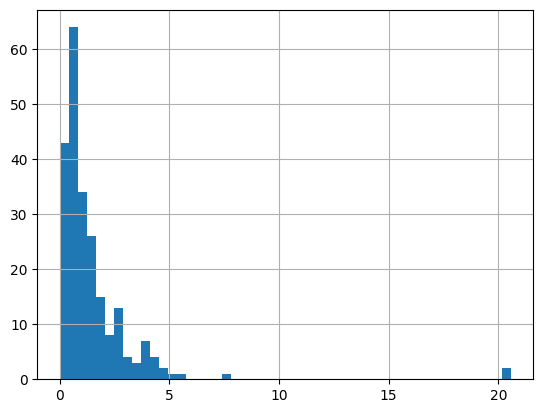

In [189]:
df_metrics_sarimax['mae'].hist(bins=50)

In [190]:
df_metrics_sarimax['mae'].agg(['mean','median','std'])

mean      1.482224
median    0.898300
std       2.156974
Name: mae, dtype: float64

## 4.2 Simple smothing

In [191]:
df_pred_ss = pd.DataFrame()
for country in df3.columns:

    # simple exponetial smooting
    model_ses = SimpleExpSmoothing(
        train[country],
        initialization_method='estimated',                              
    ).fit(smoothing_level=0.7, optimized=True)
# heuristic 
    pred_ses = model_ses.forecast(test.shape[0])
    df_pred_ss = pd.concat([df_pred_ss, pd.DataFrame(pred_ses, columns=[country])], axis=1)

In [192]:
df_metrics_ss = pd.DataFrame()
for country in df_pred_ss.columns:
    metrics_ss = metrics(test[country], df_pred_ss[country], 'simple smothing',country)
    df_metrics_ss = pd.concat([df_metrics_ss, metrics_ss], axis=0)

In [193]:
df_metrics_ss.sort_values(by='mae', ascending=False).head(20)

,Country,Model,mae,rmse,mape
0,Guyana,simple smothing,24.03068,28.90988,673.11352
0,Yemen,simple smothing,6.80645,7.03333,132.21297
0,Ukraine,simple smothing,6.38187,6.38187,304.55761
0,Caribbean,simple smothing,6.19285,6.49835,208.93552
0,Mozambique,simple smothing,6.10628,7.59743,53.69418
0,Libya,simple smothing,5.58536,5.81400,90.36752
0,Palau,simple smothing,5.31366,5.84813,110.57227
0,Ireland,simple smothing,5.26638,5.28246,162.36170
0,Macao SAR,simple smothing,4.97784,6.68112,69.07003
0,Republic of South Sudan,simple smothing,4.53530,4.53635,101.23487


<Axes: >

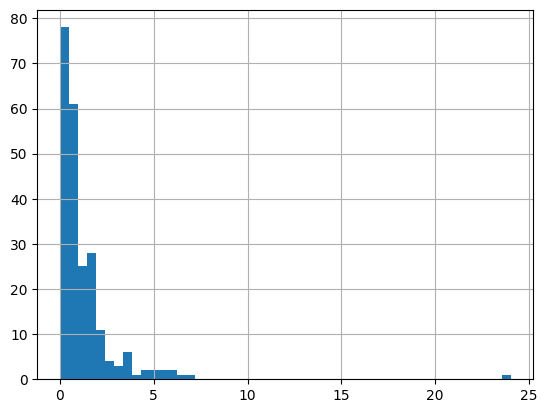

In [194]:
df_metrics_ss['mae'].hist(bins=50)

In [195]:
df_metrics_ss['mae'].agg(['mean','median','std'])

mean      1.259061
median    0.753340
std       1.968938
Name: mae, dtype: float64

## 4.3 Prophet

In [196]:

df_pred_prophet = pd.DataFrame()

for country in df3.columns:
    aux = train[[country]].copy()
    aux['ds'] = aux.index
    aux.rename(columns={country: 'y'}, inplace=True)
    aux

    # # Crie e ajuste o modelo
    model_prophet = Prophet(
        growth='linear',
        seasonality_mode='additive',
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=0.1,
        seasonality_prior_scale=0,
    )
    model_prophet.fit(aux)


    future = model_prophet.make_future_dataframe(periods=test.shape[0], freq='YS')  
    forecast = model_prophet.predict(future)
    df_pred_prophet = pd.concat([df_pred_prophet, pd.DataFrame(forecast[['yhat']][-5:].values, columns=[country])], axis=1)

11:21:31 - cmdstanpy - INFO - Chain [1] start processing


11:21:31 - cmdstanpy - INFO - Chain [1] done processing
11:21:31 - cmdstanpy - INFO - Chain [1] start processing
11:21:31 - cmdstanpy - INFO - Chain [1] done processing
11:21:31 - cmdstanpy - INFO - Chain [1] start processing
11:21:31 - cmdstanpy - INFO - Chain [1] done processing
11:21:31 - cmdstanpy - INFO - Chain [1] start processing
11:21:31 - cmdstanpy - INFO - Chain [1] done processing
11:21:31 - cmdstanpy - INFO - Chain [1] start processing
11:21:31 - cmdstanpy - INFO - Chain [1] done processing
11:21:31 - cmdstanpy - INFO - Chain [1] start processing
11:21:32 - cmdstanpy - INFO - Chain [1] done processing
11:21:32 - cmdstanpy - INFO - Chain [1] start processing
11:21:32 - cmdstanpy - INFO - Chain [1] done processing
11:21:32 - cmdstanpy - INFO - Chain [1] start processing
11:21:32 - cmdstanpy - INFO - Chain [1] done processing
11:21:32 - cmdstanpy - INFO - Chain [1] start processing
11:21:32 - cmdstanpy - INFO - Chain [1] done processing
11:21:32 - cmdstanpy - INFO - Chain [1] 

In [197]:
df_metrics_prophet = pd.DataFrame()
for country in df_pred_prophet.columns:
    metrics_prophet = metrics(test[country], df_pred_prophet[country], 'phophet',country)
    df_metrics_prophet = pd.concat([df_metrics_prophet, metrics_prophet], axis=0)

In [198]:
df_metrics_prophet.sort_values(by='mae', ascending=False).head(20)

,Country,Model,mae,rmse,mape
0,Guyana,phophet,18.71707,19.18704,317.52606
0,Equatorial Guinea,phophet,7.85506,8.90264,437.69437
0,Azerbaijan,phophet,7.60160,7.62054,296.96489
0,Venezuela,phophet,6.77428,7.02723,706.45319
0,Tajikistan,phophet,6.72677,6.75902,165.04951
0,Macao SAR,phophet,6.36106,8.83559,71.30168
0,Iraq,phophet,6.20063,6.21738,254.36364
0,Republic of South Sudan,phophet,6.17700,6.22513,137.60980
0,Turkmenistan,phophet,6.00388,6.01382,260.30076
0,Qatar,phophet,6.00219,6.02448,215.54076


<Axes: >

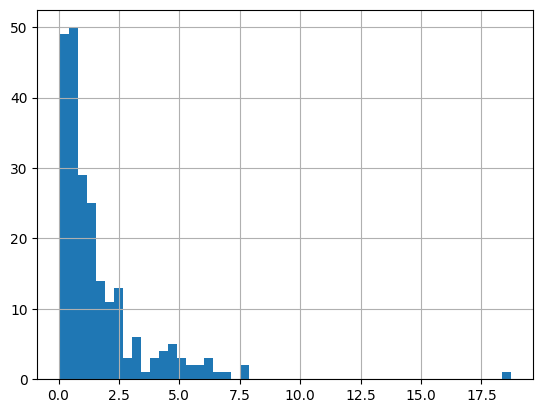

In [199]:
df_metrics_prophet['mae'].hist(bins=50)

In [200]:
df_final_metrics = pd.DataFrame()

metric = 'mae'

statistics = [
    'mean',
    'median',
    'std',
    'min',
    'max',
]
df_final_metrics = pd.concat([df_final_metrics, df_metrics_prophet[metric].agg(statistics)], axis=1)

# add simples smothing
df_final_metrics = pd.concat([df_final_metrics, df_metrics_ss[metric].agg([statistics])], axis=1)

# add sarimax
df_final_metrics = pd.concat([df_final_metrics, df_metrics_sarimax[metric].agg([statistics])], axis=1)

df_final_metrics.columns = ['prophet','simple_smoothing','sarimax']

df_final_metrics = df_final_metrics.T

df_final_metrics['cv'] = df_final_metrics['std'] / df_final_metrics['mean']  

df_final_metrics.style.highlight_min(color='lightgreen', axis=0)
# df_final_metrics

,mean,median,std,min,max,cv
prophet,1.642346,1.003945,1.961299,0.055700,18.717070,1.194206
simple_smoothing,1.259061,0.753340,1.968938,0.000000,24.030680,1.563814
sarimax,1.482224,0.898300,2.156974,0.000000,20.569550,1.455228


In [201]:
df_final_metrics = pd.DataFrame()

metric = 'rmse'

statistics = [
    'mean',
    'median',
    'std',
    'min',
    'max',
]
df_final_metrics = pd.concat([df_final_metrics, df_metrics_prophet[metric].agg(statistics)], axis=1)

# add simples smothing
df_final_metrics = pd.concat([df_final_metrics, df_metrics_ss[metric].agg([statistics])], axis=1)

# add sarimax
df_final_metrics = pd.concat([df_final_metrics, df_metrics_sarimax[metric].agg([statistics])], axis=1)

df_final_metrics.columns = ['prophet','simple_smoothing','sarimax']

df_final_metrics = df_final_metrics.T

df_final_metrics['cv'] = df_final_metrics['std'] / df_final_metrics['mean']  

df_final_metrics.style.highlight_min(color='lightgreen', axis=0)
# df_final_metrics

,mean,median,std,min,max,cv
prophet,1.726555,1.032785,2.052355,0.080230,19.187040,1.188699
simple_smoothing,1.360091,0.793105,2.275252,0.000000,28.909880,1.672868
sarimax,1.598677,0.971070,2.431278,0.000000,24.303880,1.520806


In [202]:
df_final_metrics = pd.DataFrame()

metric = 'mape'

statistics = [
    'mean',
    'median',
    'std',
    'min',
    'max',
]
df_final_metrics = pd.concat([df_final_metrics, df_metrics_prophet[metric].agg(statistics)], axis=1)

# add simples smothing
df_final_metrics = pd.concat([df_final_metrics, df_metrics_ss[metric].agg([statistics])], axis=1)

# add sarimax
df_final_metrics = pd.concat([df_final_metrics, df_metrics_sarimax[metric].agg([statistics])], axis=1)

df_final_metrics.columns = ['prophet','simple_smoothing','sarimax']

df_final_metrics = df_final_metrics.T

df_final_metrics['cv'] = df_final_metrics['std'] / df_final_metrics['mean']  

df_final_metrics.style.highlight_min(color='lightgreen', axis=0)
# df_final_metrics

,mean,median,std,min,max,cv
prophet,57.816669,32.222000,76.873557,0.936100,706.453190,1.329609
simple_smoothing,42.098371,24.753465,66.029543,0.000000,673.113520,1.568458
sarimax,46.247781,31.770445,54.678141,0.000000,562.484240,1.182287


# 5.0 cross validation

## 5.1 Simple smothing

mean mae for all countrys 3.7541548752331964
median mae for all countrys 3.0548487775568036
std mae for all countrys 2.375351945163901
std mae for all countrys 21.960004251189652
std mae for all countrys 1.0535072712366245
cv mae for all countrys 0.6327261458589536


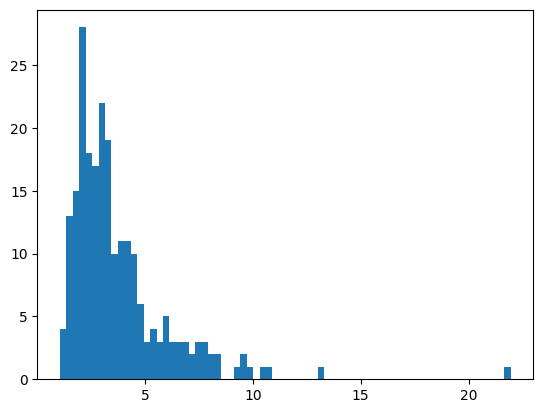

In [203]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Crie um DataFrame vazio para armazenar as métricas finais

df_final_metrics_cv = pd.DataFrame()

# Defina a métrica que você está calculando (por exemplo, 'mae')
metric = 'mae'

# Lista das estatísticas que você deseja calcular
statistics = [
    'mean',
    'median',
    'std',
    'min',
    'max'
]

# Crie um objeto TimeSeriesSplit com o número de splits desejado
n_splits = 5  # Número de folds para cross-validation
tscv = TimeSeriesSplit(n_splits=n_splits)

# Loop através das divisões da avaliação cruzada
for country in df3.columns:
    final_metrics_cv = pd.DataFrame()
    for train_idx, test_idx in tscv.split(train[country]):
        train_data = train[country].iloc[train_idx]
        test_data = train[country].iloc[test_idx]
        
        # Ajuste o modelo Simple Exponential Smoothing (SES)
        model_ses = SimpleExpSmoothing(train_data, initialization_method='estimated').fit()
        
        # Faça previsões no conjunto de teste
        forecast = model_ses.forecast(len(test_data))
        
        # Calcule a métrica desejada (MAE)
        mae = mean_absolute_error(test_data, forecast)
        
        # Adicione o MAE à lista de métricas
        final_metrics_cv = pd.concat([final_metrics_cv, pd.DataFrame({country: [mae]})], ignore_index=True)
    df_final_metrics_cv = pd.concat([df_final_metrics_cv, final_metrics_cv], axis=1)


aux = df_final_metrics_cv.mean()

print("mean mae for all countrys",aux.values.mean())
print("median mae for all countrys",np.median(aux.values))
print("std mae for all countrys",aux.values.std())
print("std mae for all countrys",aux.values.max())
print("std mae for all countrys",aux.values.min())
print("cv mae for all countrys",aux.values.std() / aux.values.mean())
plt.hist(aux.values, bins=70);

## 5.2 Auto arima

mean mae for all countrys 3.6185197164891822
median mae for all countrys 3.022688031090322
std mae for all countrys 2.2329373541431314
std mae for all countrys 19.562123519079215
std mae for all countrys 1.0991255411988314
cv mae for all countrys 0.6170858608197961


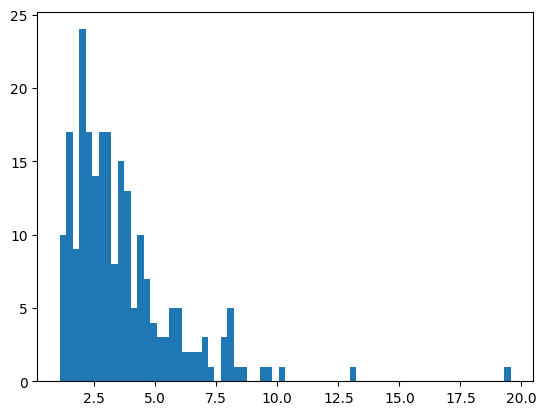

In [204]:
# Crie um DataFrame vazio para armazenar as previsões do SARIMA
df_final_metrics_cv = pd.DataFrame()

# Defina o número de splits desejado para a avaliação cruzada
n_splits = 5

# Crie um objeto TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits)

# Loop através das divisões da avaliação cruzada

    
    # Loop através das colunas (países)
for country in df3.columns:
    final_metrics_cv = pd.DataFrame()
    for train_idx, test_idx in tscv.split(train[country]):
        train_data = train[country].iloc[train_idx]
        test_data = train[country].iloc[test_idx]
        model_sarimax = auto_arima(
            train_data,
            m=1,
            test='adf',
            seasonal=False,
            stepwise=True,
            d=0,
            start_p=0,
            max_p=1,
            start_q=0,
            max_q=1,
        )
            
            
        pred_sarimax = model_sarimax.predict(len(test_data))

        mae = mean_absolute_error(test_data, pred_sarimax)

        final_metrics_cv = pd.concat([final_metrics_cv, pd.DataFrame({country: [mae]})], ignore_index=True)

    df_final_metrics_cv = pd.concat([df_final_metrics_cv, final_metrics_cv], axis=1)

aux = df_final_metrics_cv.mean()

print("mean mae for all countrys",aux.values.mean())
print("median mae for all countrys",np.median(aux.values))
print("std mae for all countrys",aux.values.std())
print("std mae for all countrys",aux.values.max())
print("std mae for all countrys",aux.values.min())
print("cv mae for all countrys",aux.values.std() / aux.values.mean())
plt.hist(aux.values, bins=70);


In [205]:
mean_absolute_error(test_data, pred_sarimax)

1.570044876697797

# 6.0 Fine tuning

In [206]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# Crie um DataFrame vazio para armazenar os resultados
results = pd.DataFrame(columns=['country', 'alpha', 'smoothing_level', 'optimized', 'mae_mean', 'mae_std'])

# Defina a lista de países
countries = df3.columns

# Defina os parâmetros que deseja ajustar
param_grid = {'alpha': [0.2, 0.4, 0.6, 0.8], 'smoothing_level': [None, 0.2, 0.4, 0.6, 0.8], 'optimized': [True, False]}

# Crie um objeto TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Loop através dos países
for country in countries:
    # Crie o pipeline com o modelo SES e o GridSearchCV
    pipe = Pipeline([
        ('model', SimpleExpSmoothing(initialization_method='heuristic'))
    ])
    
    # Crie o GridSearchCV com o TimeSeriesSplit
    grid_search = GridSearchCV(pipe, param_grid, cv=tscv, scoring='neg_mean_absolute_error')
    
    # Ajuste o GridSearchCV aos dados
    grid_search.fit(train[country])
    
    # Extrair os melhores parâmetros e resultados
    best_params = grid_search.best_params_
    best_alpha = best_params['alpha']
    best_smoothing_level = best_params['smoothing_level']
    best_optimized = best_params['optimized']
    
    cv_results = pd.DataFrame(grid_search.cv_results_)
    mae_mean = -cv_results[(cv_results['param_alpha'] == best_alpha) &
                            (cv_results['param_smoothing_level'] == best_smoothing_level) &
                            (cv_results['param_optimized'] == best_optimized)]['mean_test_score'].values[0]
    
    mae_std = cv_results[(cv_results['param_alpha'] == best_alpha) &
                         (cv_results['param_smoothing_level'] == best_smoothing_level) &
                         (cv_results['param_optimized'] == best_optimized)]['std_test_score'].values[0]
    
    # Adicione os resultados ao DataFrame
    results = results.append({'country': country, 'alpha': best_alpha, 'smoothing_level': best_smoothing_level,
                              'optimized': best_optimized, 'mae_mean': mae_mean, 'mae_std': mae_std}, ignore_index=True)

# Exiba os resultados
print(results)


TypeError: SimpleExpSmoothing.__init__() missing 1 required positional argument: 'endog'